# Intro

[Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) is a dataset crafted by Zalando, containing 70,000 gray scale images of different apparel:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

Each image is a `28x28`type image, just like the MNIST dataset, Zalando's team [hope to replace](https://github.com/zalandoresearch/fashion-mnist/blob/master/README.md#to-serious-machine-learning-researchers) because: 
- MNIST is too easy. (...)
- MNIST is overused. (...)
- MNIST can not represent modern CV tasks (...) 

# Preparation

In [0]:
import pandas as pd

root_path = '/content/drive/notebooks/datasets/'
root_folder = 'zalendo-mnist/'

train_file = 'fashion-mnist_train.csv'
test_file = 'fashion-mnist_test.csv'

train = pd.read_csv(root_path+root_folder+train_file)
test = pd.read_csv(root_path+root_folder+test_file)

The training set is equally distributed over the 10 classes.

In [166]:
train['label'].value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

Let's define some helper functions for visualization.

In [0]:
image_slice = slice(1,None)
image_dims = (28, 28)
input_size = image_dims+(1,)

classes = ['T-shirt/top',
        'Trouser',
        'Pullover',
        'Dress',
        'Coat',
        'Sandal',
        'Shirt',
        'Sneaker',
        'Bag',
        'Ankle boot']

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import random

def plot_image(image, title=None):
  plt.axis('off')
  plt.imshow(image, interpolation='nearest')
  if(title is not None):
    plt.title(title)

def get_class_name(logit, classes=classes):
  if(logit < len(classes) and logit >= 0):
    return classes[logit]
  else:
    return 'Unknown'
  
def get_image(df, index=None, 
              image_slice=image_slice, 
              image_dimensions=image_dims):
  if(index is None):
    index = random.randint(0, len(df))
  image = df.iloc[index,image_slice]
  return np.resize(image, image_dimensions), df.iloc[index, 0]

def plot_random_samples(df, grid_shape=(8,8),
                     plot=plot_image, 
                     get_image=get_image,
                     get_class_name=get_class_name):
  plt.figure(figsize=(8,10))
  for index in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(grid_shape[0], grid_shape[1], index + 1)
    image, label = get_image(df)
    plot(image, get_class_name(label))

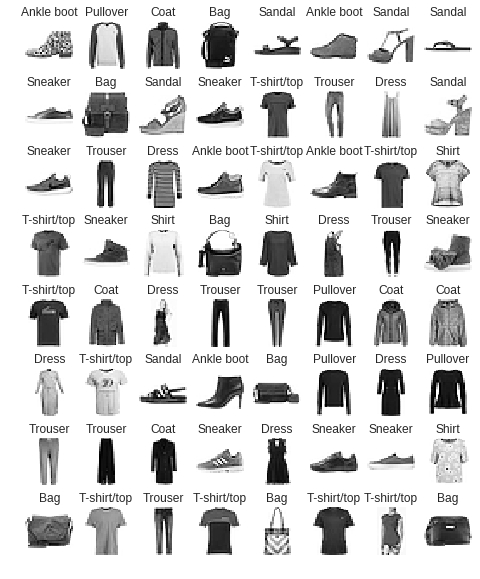

In [176]:
plot_random_samples(train)

Since the data is equally distributed between class we don't need to handle data imbalance in the train, validation and test split.

We also need to resize our flat images into `(28,28,1)` matrices, normalize them and convert our labels in a hot encoding manner.

In [0]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

def process_labels(df, label_index=0):
  return to_categorical(np.array(df.iloc[:,label_index]))

def prepare_image_feature(df, image_slice=image_slice):
  return np.array(df.iloc[:, image_slice])

def reshape_normalize_image(X, image_shape=image_dims):
  return (X.reshape(len(X), image_shape[0], image_shape[1], 1).astype('float32')) / 255

y = process_labels(train)
X = prepare_image_feature(train)
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                    stratify=y, 
                                                    test_size=0.10, 
                                                    random_state=4422)

y_test = process_labels(test)
X_test = prepare_image_feature(test)

X_train = reshape_normalize_image(X_train)
X_test = reshape_normalize_image(X_test)
X_val = reshape_normalize_image(X_val)


# Data Augmentation

Data augmentation in Keras is made easy thanks to the [ImageDataGenerator](https://keras.io/preprocessing/image/) class.

- `width_shift_range` and `height_shift_range` randomly shift images horizontally/vertically by a fraction of the total width/height.
- `horizontal_flip` randomly flip the image horizontaly
- `rotation_range` randomly rotate the image in the +/- range

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    featurewise_center=True,
    samplewise_center=True)

datagen_train.fit(X_train)

datagen_val = ImageDataGenerator(
    rotation_range=3,
    horizontal_flip=True,
    featurewise_center=True,
    samplewise_center=True)

datagen_val.fit(X_val)

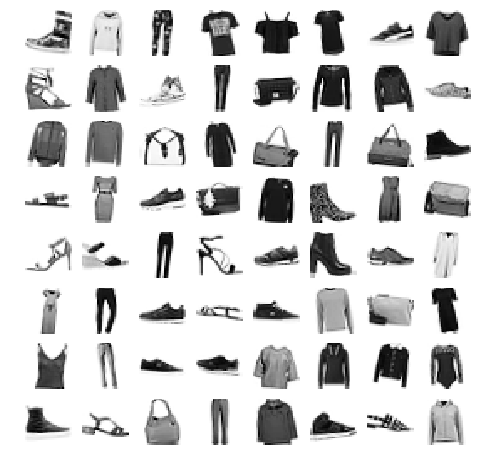

In [181]:
# Let's plot the first augmented examples
subplot_dims = (8,8)
index = 0

max_examples = subplot_dims[0]*subplot_dims[1]
for x_batch, y_batch in datagen_train.flow(X_train, y_train, batch_size=max_examples):
  plt.figure(figsize=(8,8))
  for index in range(max_examples):
    plt.subplot(subplot_dims[0], subplot_dims[1], index + 1)
    plot_image(x_batch[index, :,:,0])
  break

# Model

- An official benchmark is recorded for everything but neural network in sklearn [here](http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/).
- Another benchmark including neural network is tracked [here](https://github.com/zalandoresearch/fashion-mnist/blob/master/README.md#benchmark).

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

num_classes = 10

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=input_size))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [247]:
batch_size = 256
epochs = 150

train_step_per_epoch = len(X_train) / batch_size
val_step_per_epoch = len(X_val) / batch_size

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0.01,
                              patience=10,
                              mode='auto')

history = model.fit_generator(generator=datagen_train.flow(X_train, y_train, batch_size=batch_size),
                    epochs=epochs,
                    steps_per_epoch=train_step_per_epoch,
                    validation_data=datagen_val.flow(X_val, y_val, batch_size=batch_size),
                    validation_steps=val_step_per_epoch,
                    callbacks=[early_stopping],
                    initial_epoch=0,
                    workers=10, 
                    use_multiprocessing=True,
                    verbose=2)

Epoch 1/150
 - 22s - loss: 0.8410 - acc: 0.6926 - val_loss: 0.5250 - val_acc: 0.8042
Epoch 2/150
 - 18s - loss: 0.5796 - acc: 0.7839 - val_loss: 0.4431 - val_acc: 0.8397
Epoch 3/150
 - 18s - loss: 0.5216 - acc: 0.8055 - val_loss: 0.3917 - val_acc: 0.8558
Epoch 4/150
 - 19s - loss: 0.4811 - acc: 0.8228 - val_loss: 0.3629 - val_acc: 0.8665
Epoch 5/150
 - 18s - loss: 0.4525 - acc: 0.8346 - val_loss: 0.3402 - val_acc: 0.8720
Epoch 6/150
 - 18s - loss: 0.4300 - acc: 0.8414 - val_loss: 0.3308 - val_acc: 0.8780
Epoch 7/150
 - 18s - loss: 0.4156 - acc: 0.8479 - val_loss: 0.3093 - val_acc: 0.8857
Epoch 8/150
 - 20s - loss: 0.4042 - acc: 0.8534 - val_loss: 0.2955 - val_acc: 0.8955
Epoch 9/150
 - 18s - loss: 0.3951 - acc: 0.8556 - val_loss: 0.2908 - val_acc: 0.8928
Epoch 10/150
 - 18s - loss: 0.3809 - acc: 0.8604 - val_loss: 0.2849 - val_acc: 0.8963
Epoch 11/150
 - 18s - loss: 0.3771 - acc: 0.8625 - val_loss: 0.2804 - val_acc: 0.8977
Epoch 12/150
 - 19s - loss: 0.3715 - acc: 0.8635 - val_loss: 0.

Let's plot the accuracy and the validation accuracy together

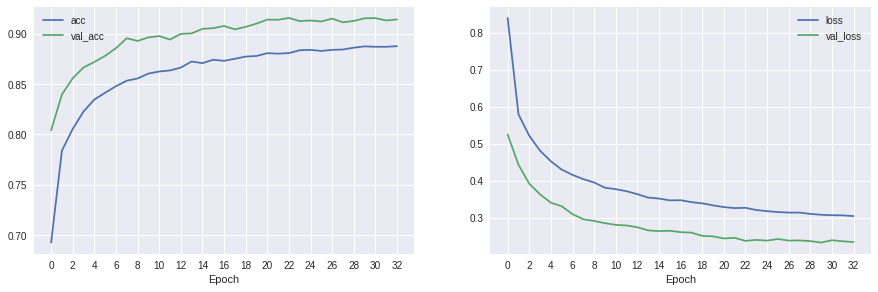

In [254]:
def plot_history(keras_history,
                 metrics=['acc'], 
                 plot_validation=True, 
                 figure_size=(15,10)):
  plt.figure(figsize=figure_size)
  
  for index, metric in enumerate(metrics):
    ax = plt.subplot(2, 2, index + 1)
    ax.plot(history.history[metric], label=metric)
    if(plot_validation):
      val = 'val_{0}'.format(metric)
      ax.plot(history.history[val], label=val)
    
    ax.legend(framealpha=0.8, fancybox=True)
    max_epoch = len(history.history[metric])
    step = int(max_epoch/15) if (max_epoch > 30) else 2

    plt.xticks(np.arange(0, len(history.history[metric]), step=step))
    ax.set(xlabel='Epoch')
    
plot_history(keras_history=history, metrics=['acc', 'loss'])

stopped_at_epoch = len(history.history['acc'])

In [255]:
evaluations =  model.evaluate(x=X_val, y=y_val, batch_size=batch_size)
evaluations

6000/6000 [==============================] - 0s 32us/step


[5.118322977701823, 0.24266666678587595]

Let's have a look at the precision, recall and f1-score for each class. 

Reminder:

- Precision answer to the question "how many selected items are relevant ?"
- Recall answers to the question "how many relevant items are selected ?"

In [256]:
from sklearn.metrics import classification_report

y_pred_test = to_categorical(model.predict(X_test).argmax(axis=1))

print(classification_report(y_test, y_pred_test, target_names=classes))

             precision    recall  f1-score   support

T-shirt/top       0.67      0.00      0.01      1000
    Trouser       1.00      0.13      0.23      1000
   Pullover       0.26      0.05      0.09      1000
      Dress       0.89      0.02      0.03      1000
       Coat       0.16      1.00      0.28      1000
     Sandal       0.99      0.17      0.29      1000
      Shirt       0.04      0.05      0.05      1000
    Sneaker       0.89      0.65      0.75      1000
        Bag       0.19      0.03      0.05      1000
 Ankle boot       0.31      0.36      0.34      1000

avg / total       0.54      0.25      0.21     10000



We can see that T-shirt and Shirt are almost classifed as a random classifier.

This is probably because we tested our model on rotated/shifted images only and not on 'raw' datas.

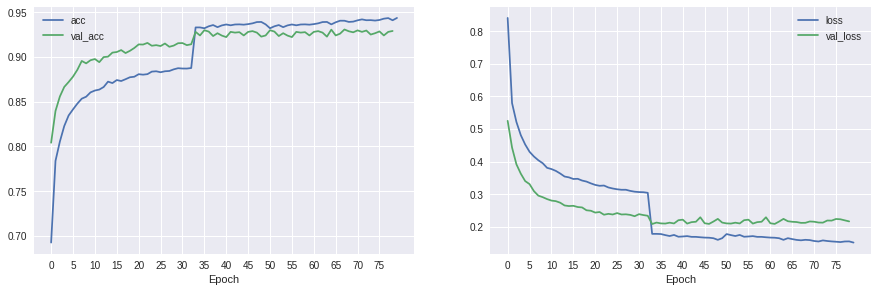

In [275]:
history_sup = model.fit(X_train, y_train, 
                     initial_epoch=stopped_at_epoch, 
                     verbose=0,
                     validation_data=(X_val, y_val),
                     epochs=stopped_at_epoch+15)

def concatenate_history(history, history2, metrics=['acc', 'loss'], validation=True):
  for metric in metrics:
    history.history[metric] = history.history[metric] + history_sup.history[metric]
    if(validation):
      history.history['val_'+metric] = history.history['val_'+metric] + history_sup.history['val_'+metric]
     
  return history

history = concatenate_history(history, history_sup)
plot_history(keras_history=history, metrics=['acc', 'loss'])

In [276]:
from sklearn.metrics import classification_report

y_pred_test = to_categorical(model.predict(X_test).argmax(axis=1))

print(classification_report(y_test, y_pred_test, target_names=classes))

             precision    recall  f1-score   support

T-shirt/top       0.89      0.85      0.87      1000
    Trouser       0.99      0.99      0.99      1000
   Pullover       0.90      0.89      0.89      1000
      Dress       0.94      0.95      0.94      1000
       Coat       0.88      0.91      0.89      1000
     Sandal       0.99      0.98      0.99      1000
      Shirt       0.79      0.79      0.79      1000
    Sneaker       0.96      0.98      0.97      1000
        Bag       0.98      0.99      0.99      1000
 Ankle boot       0.98      0.97      0.98      1000

avg / total       0.93      0.93      0.93     10000

